In [2]:
import numpy as np
import pandas as pd

# visualization
import altair as alt
from vega_datasets import data

# # set decimals
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

# enable altair visualizations
alt.renderers.enable()
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [3]:
counties = pd.read_csv('data/Counties_Population.csv')
counties['County'] = counties.Name.str.split(' County').str[0]

In [4]:
ga_covid = pd.read_csv('cases\Georgia_Counties_Covid_Mar24.csv', encoding = "ISO-8859-1")
tn_covid = pd.read_csv('cases\Tennessee_Counties_Covid_Mar24.csv', encoding = "ISO-8859-1")
al_covid = pd.read_csv('cases\Alabama_Counties_Covid_Mar24.csv', encoding = "ISO-8859-1")
prior = pd.read_csv('cases\Georgia_Counties_Covid_Mar22.csv', encoding = "ISO-8859-1")
prior.columns = ['County', 'Prior']

FileNotFoundError: [Errno 2] File b'cases\\Tennessee_Counties_Covid_Mar24.csv' does not exist: b'cases\\Tennessee_Counties_Covid_Mar24.csv'

In [9]:
fips = pd.read_csv('FIPS_County_Codes.csv')
fips['CountyState'] = fips.Name + fips.State

In [10]:
df = pd.merge(counties, ga_covid, on='County', how='outer')
df = pd.merge(df, prior, on='County', how='outer')
df['CountyState'] = df.County + ' GA'
df =  pd.merge(df, fips, on='CountyState')
df['id'] = df.FIPS.astype('str')
df.Cases = df.Cases.fillna(0).astype('int')
df.Prior = df.Prior.fillna(0).astype('int')
df['Incr'] = np.round((df.Cases / df.Prior - 1),4)
df =  df.replace([np.inf, -np.inf], np.nan)
df.Incr = df.Incr.fillna(0.0000)

df['Population'] = df['2020 Population'].str.replace(',', '').fillna(0).astype('int')
df['CasesPer100K'] = np.round(df.Cases / (df['Population'] / 100000),2)
df =  df.replace([np.inf, -np.inf], np.nan)
df.CasesPer100K =  df.CasesPer100K.fillna(0)
# df.CasesPer100K = np.round(df.CasesPer100K, 1)

In [11]:
df.sort_values(by=['CasesPer100K'], inplace=True, ascending=False)
df.head(50)

,Name_x,2020 Population,Growth Since 2010,County,Cases,Prior,CountyState,FIPS,Name_y,State,id,Incr,Population,CasesPer100K
46,Dougherty County,"91,243",-3.46%,Dougherty,101,52,Dougherty GA,13095,Dougherty,GA,13095,0.9423,91243,110.69
3,Baker County,"3,092",-9.99%,Baker,3,0,Baker GA,13007,Baker,GA,13007,0.0000,3092,97.02
87,Lee County,"29,764",4.74%,Lee,24,16,Lee GA,13177,Lee,GA,13177,0.5000,29764,80.63
7,Bartow County,"106,408",6.32%,Bartow,76,56,Bartow GA,13015,Bartow,GA,13015,0.3571,106408,71.42
48,Early County,"10,247",-6.71%,Early,5,2,Early GA,13099,Early,GA,13099,1.5000,10247,48.79
134,Terrell County,"8,611",-9.60%,Terrell,3,2,Terrell GA,13273,Terrell,GA,13273,0.5000,8611,34.84
124,Seminole County,"8,315",-4.72%,Seminole,2,0,Seminole GA,13253,Seminole,GA,13253,0.0000,8315,24.05
21,Carroll County,"118,121",6.74%,Carroll,26,16,Carroll GA,13045,Carroll,GA,13045,0.6250,118121,22.01
158,Worth County,"20,299",-6.46%,Worth,4,2,Worth GA,13321,Worth,GA,13321,1.0000,20299,19.71
114,Polk County,"42,470",2.26%,Polk,8,4,Polk GA,13233,Polk,GA,13233,1.0000,42470,18.84


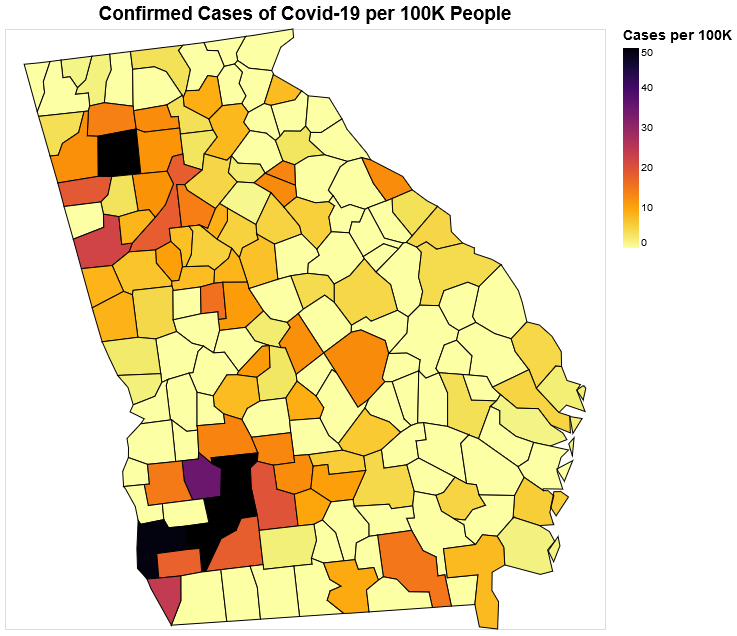

In [14]:
min_value = 0
max_value = 50


counties = alt.topo_feature(data.us_10m.url, 'counties')
states = alt.topo_feature(data.us_10m.url, 'states')
source = df.copy()

width = 600
height = 600
font_size = 30 / (960 / width)

foreground = alt.Chart(counties).mark_geoshape(
    stroke='black'
    ).encode(
    color=alt.Color('CasesPer100K:Q', sort="descending", scale=alt.Scale(
        scheme='inferno', domain=(min_value,max_value)
    ), legend=alt.Legend(title="Cases per 100K", tickCount=6)), 
    tooltip=[
        alt.Tooltip('County:O', title="County"), 
        alt.Tooltip('Cases:Q', title="Cases"), 
        alt.Tooltip('CasesPer100K:Q', title="CasesPer100K"), 
        alt.Tooltip('Population:Q', title="Population"), 
        alt.Tooltip('Incr:Q', title="2 Day Growth Rate", format='.2%')
    ]
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['CasesPer100K', 'County', 'Cases', 'Population', 'Incr'])
).project(
    type='albersUsa'
).properties(
    title="Confirmed Cases of Covid-19 per 100K People",
    width=width,
    height=height
).configure_title(fontSize=font_size, anchor="middle").configure_legend(titleColor='black', titleFontSize=14) 

# # generate background for states with no data; create boundary lines for states
# background = alt.Chart(states).mark_geoshape(
#     fill='lightgray',
#     stroke='black'
# ).properties(
#     width=width,
#     height=height
# ).project('albersUsa')

# config = alt.layer(background, foreground).configure_title(fontSize=font_size, anchor="middle").configure_legend(titleColor='black', titleFontSize=14) 

foreground

In [15]:
foreground.save('ga_covid_update.html')

In [41]:
# foreground.save('ga_covid.png')